


#Imports




In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout,Embedding,Flatten
from keras import optimizers
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import gc

Using TensorFlow backend.


#Fetch data

In [7]:
!wget http://www.cs.ucl.ac.uk/staff/D.Jones/coursework/cyto.fasta
!wget http://www.cs.ucl.ac.uk/staff/D.Jones/coursework/secreted.fasta
!wget http://www.cs.ucl.ac.uk/staff/D.Jones/coursework/mito.fasta
!wget http://www.cs.ucl.ac.uk/staff/D.Jones/coursework/nucleus.fasta
!wget http://www.cs.ucl.ac.uk/staff/D.Jones/coursework/blind.fasta

--2019-03-29 08:18:10--  http://www.cs.ucl.ac.uk/staff/D.Jones/coursework/cyto.fasta
Resolving www.cs.ucl.ac.uk (www.cs.ucl.ac.uk)... 128.16.10.31
Connecting to www.cs.ucl.ac.uk (www.cs.ucl.ac.uk)|128.16.10.31|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/cyto.fasta [following]
--2019-03-29 08:18:11--  http://www0.cs.ucl.ac.uk/staff/D.Jones/coursework/cyto.fasta
Resolving www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)... 128.16.6.8
Connecting to www0.cs.ucl.ac.uk (www0.cs.ucl.ac.uk)|128.16.6.8|:80... connected.
HTTP request sent, awaiting response... 200 Document follows
Length: 2350203 (2.2M) [text/plain]
Saving to: ‘cyto.fasta’

cyto.fasta          100%[===================>]   2.24M  15.6KB/s    in 2m 26s  

2019-03-29 08:20:39 (15.7 KB/s) - ‘cyto.fasta’ saved [2350203/2350203]

--2019-03-29 08:20:46--  http://www.cs.ucl.ac.uk/staff/D.Jones/coursework/secreted.fasta
Resolving www.cs.ucl.ac.uk (www.cs

#Construct dataset

~~~~~~~
9222 9222  sanity check
23 unique symbols
['M', 'G', 'Q', 'V', 'R', 'E', 'A', 'P', 'L', 'I', 'S', 'D', 'T', 'F', 'N', 'H', 'C', 'K', 'W', 'Y', 'X', 'U', 'B']
Max length: 13100, Avg length: 546.613375243876 , STD: 514.3080288377134
[ 1. 18. 20. ...  0.  0.  0.]
[0. 0. 0. 1.]
3.0
~~~~~~~


0

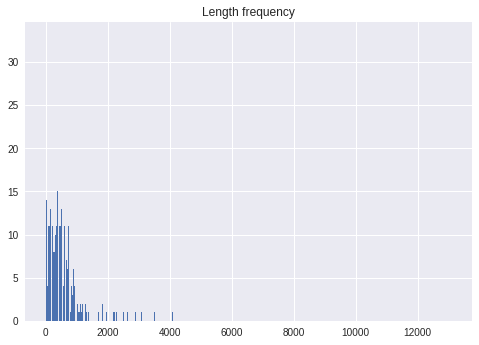

In [8]:

###
# Gather label data and vocabulary range, check maximal sequence.
###
Y = []
chas = []
max_len = 0
lengths = []
files = ['cyto.fasta','mito.fasta','nucleus.fasta','secreted.fasta']
typ = ['cyt','mit','nuc','sec']
Y =np.zeros((9222,4)) # One hot encoding
Y_tag = np.zeros(9222) # Class numeric representation
lables = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
count = 0
for i in range(4):
    file = files[i]
    with open(file, 'r') as myfile:
        dat=myfile.read()
    dat = dat.split('>')
    dat = dat[1:]
    for p in range(len(dat)):
        x = (dat[p].split('\n'))
        x = x[1:-1]
        x = ''.join(x)
        for c in x:
            if not c in chas:
                chas.append(c)
        lengths.append(len(x))
        if(len(x)>0):
            #X.append(x)
            Y[count,:] = lables[i]
            Y_tag[count] = i
            count +=1
            if(len(x)>max_len):
              max_len = len(x)
              
              
###
# Gather protein sequential data 
# convert to numeric representation
###             
count = 0
X = np.zeros((9222,max_len)) 
for i in range(4):
    file = files[i]
    with open(file, 'r') as myfile:
        dat=myfile.read()
    dat = dat.split('>')
    dat = dat[1:]
    for p in range(len(dat)):
        x = (dat[p].split('\n'))
        x = x[1:-1]
        x = ''.join(x)
        if(len(x)>0):
          for ch in range(len(x)):
            ind = chas.index(x[ch]) + 1 # shift by one, taking padding value into account
            X[count,ch] = ind 
          count +=1
          
          
          
#Merge [X,Y] -> shufle -> split back  
data_tree = np.concatenate((X,Y_tag.reshape((9222,1))),axis = 1)
np.random.shuffle(data_tree)
X_tree = data_tree[:,:13100]
Y_tree = data_tree[:,-1:]
#Merge [X,Y] -> shufle -> split back for one hot encodings (needed for ANN and LSTM)
data = np.concatenate((X,Y),axis = 1)
np.random.shuffle(data)
Xx = data[:,:13100]
Yy = data[:,-4:]

#Alocate resources, not enough ram otherwise

          
num = 8000 # arbitrary protein for inspection
print('~~~~~~~')
print(len(X),len(Y),' sanity check')
print(len(chas),'unique symbols')
print(chas)
lengths = np.array(lengths)
print('Max length: {1}, Avg length: {0} , STD: {2}'.format(lengths.mean(),lengths.max(),lengths.std()))
print(X[num])
print(Y[num])
print(Y_tag[num])
print('~~~~~~~')



length_count = np.zeros(13100)
for i in lengths:
    length_count[i-1] += 1
plt.bar(range(13100),length_count)
plt.title('Length frequency')


del data
del data_tree
del X
del Y
del lengths
gc.collect()

#decision tree classifier

In [12]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_tree, Y_tree)
X_train, X_test, y_train, y_test = train_test_split(X_tree, Y_tree, test_size = 0.8, random_state = 100)
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=4, min_samples_leaf=6)
clf_entropy.fit(X_train, y_train)
y_pred = clf_entropy.predict(X_test)
print( "Accuracy is ", accuracy_score(y_test,y_pred)*100,' %')

Accuracy is  42.952019517484416  %


#Feed forward NN with dropots and batch normalization

In [9]:
#Build and compile model
model1 = Sequential()
model1.add(Dense(256, input_shape=(13100,),activation="relu"))
model1.add(BatchNormalization())
model1.add(Dropout(0.8))
model1.add(Dense(32, activation="relu"))
model1.add(BatchNormalization())
model1.add(Dropout(0.7))
model1.add(Dense(4, activation="sigmoid"))

opti = optimizers.adam(0.0001)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               3353856   
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total para

In [10]:
history = model1.fit(Xx, Yy, validation_split=0.3, epochs=50, batch_size=256)

Instructions for updating:
Use tf.cast instead.
Train on 6455 samples, validate on 2767 samples
Epoch 1/50
6455/6455 [==============================] - 4s 679us/step - loss: 1.0003 - acc: 0.5008 - val_loss: 0.7225 - val_acc: 0.5519
Epoch 2/50
6455/6455 [==============================] - 1s 167us/step - loss: 0.8702 - acc: 0.5210 - val_loss: 0.7097 - val_acc: 0.4900
Epoch 3/50
6455/6455 [==============================] - 1s 168us/step - loss: 0.7896 - acc: 0.5547 - val_loss: 0.6660 - val_acc: 0.5941
Epoch 4/50
6455/6455 [==============================] - 1s 169us/step - loss: 0.7311 - acc: 0.5777 - val_loss: 0.6366 - val_acc: 0.6126
Epoch 5/50
6455/6455 [==============================] - 1s 167us/step - loss: 0.6991 - acc: 0.6090 - val_loss: 0.6059 - val_acc: 0.6382
Epoch 6/50
6455/6455 [==============================] - 1s 169us/step - loss: 0.6620 - acc: 0.6440 - val_loss: 0.5869 - val_acc: 0.6941
Epoch 7/50
6455/6455 [==============================] - 1s 168us/step - loss: 0.6388 - a

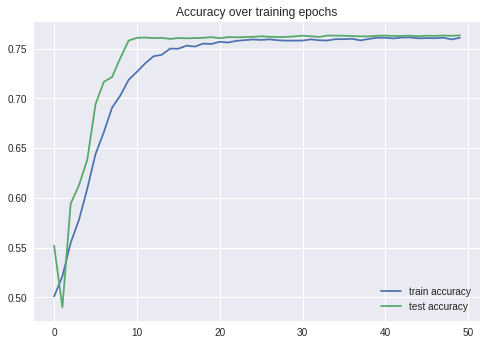

Validation acuracy after training:  0.7633718825179314


In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train accuracy','test accuracy'])
plt.title('Accuracy over training epochs')
plt.show()
print('Validation acuracy after training: ',history.history['val_acc'][-1])

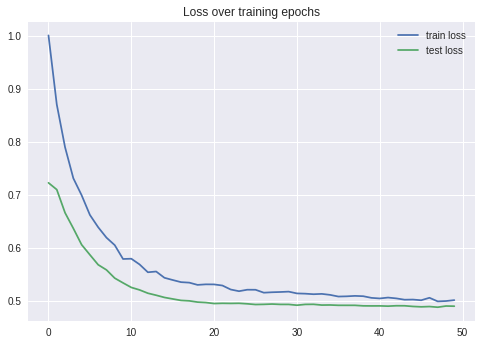

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss','test loss'])
plt.title('Loss over training epochs')
plt.show()

#LSTM

In [29]:
model2 = Sequential()
model2.add(Embedding(input_dim=24,output_dim=4,input_length=13100))
model2.add(LSTM(64))
model2.add(BatchNormalization())
model2.add(Dropout(0.8))
model2.add(Dense(4, activation="sigmoid"))


opti = optimizers.adam(0.0001)
model2.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])


model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13100, 4)          96        
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                17664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 18,276
Trainable params: 18,148
Non-trainable params: 128
_________________________________________________________________


In [30]:
history2 = model2.fit(Xx, Yy, validation_split=0.2, epochs=5, batch_size=256)

Train on 7377 samples, validate on 1845 samples
Epoch 1/5
7377/7377 [==============================] - 969s 131ms/step - loss: 0.6912 - acc: 0.7376 - val_loss: 0.6881 - val_acc: 0.7500
Epoch 2/5
7377/7377 [==============================] - 958s 130ms/step - loss: 0.6869 - acc: 0.7443 - val_loss: 0.6840 - val_acc: 0.7500
Epoch 3/5
7377/7377 [==============================] - 958s 130ms/step - loss: 0.6824 - acc: 0.7453 - val_loss: 0.6819 - val_acc: 0.7500
Epoch 4/5
7377/7377 [==============================] - 967s 131ms/step - loss: 0.6775 - acc: 0.7444 - val_loss: 0.6792 - val_acc: 0.7500
Epoch 5/5
7377/7377 [==============================] - 960s 130ms/step - loss: 0.6724 - acc: 0.7460 - val_loss: 0.6726 - val_acc: 0.7500


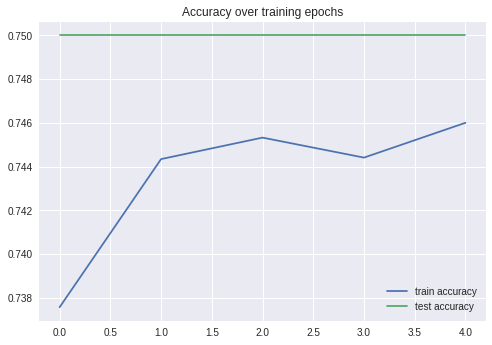

Validation acuracy after training:  0.75


In [32]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.legend(['train accuracy','test accuracy'])
plt.title('Accuracy over training epochs')
plt.show()
print('Validation acuracy after training: ',history2.history['val_acc'][-1])

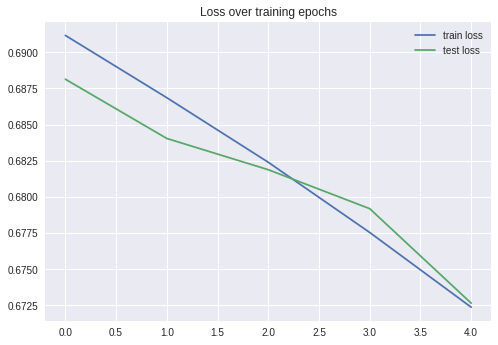

In [33]:
['acc', 'loss', 'val_acc', 'val_loss']
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train loss','test loss'])
plt.title('Loss over training epochs')
plt.show()

#Load test data

In [22]:
X_test = np.zeros((20,max_len)) 
names = []
count = 0
with open('blind.fasta', 'r') as myfile:
    dat=myfile.read()
dat = dat.split('>')
dat = dat[1:]
for p in range(len(dat)):
    x = (dat[p].split('\n'))
    names.append(x[0])
    x = x[1:-1]
    x = ''.join(x)
    if(len(x)>0):
      for ch in range(len(x)):
        ind = chas.index(x[ch]) + 1 # shift by one, taking padding value into account
        X_test[count,ch] = ind 
      count += 1
print(X_test)

[[ 1.  6. 11. ...  0.  0.  0.]
 [ 1.  8.  2. ...  0.  0.  0.]
 [ 1. 12. 11. ...  0.  0.  0.]
 ...
 [ 1. 13. 13. ...  0.  0.  0.]
 [ 1. 15. 13. ...  0.  0.  0.]
 [ 1.  6.  2. ...  0.  0.  0.]]


#Predict using ANN

In [28]:
typs = ['Cytosolic','Mitochondrial','Nuclear','Secreted']
pred = model1.predict(X_test)
maxim = np.argmax(pred,axis = 1)
for i in range(20):
  name = names[i]
  location =typs[ maxim[i] ]
  conf = pred[i,maxim[i]]
  print('{0}, {1}, {2}%'.format(name,location,100*conf))

SEQ677, Nuclear, 40.24902880191803%
SEQ231, Nuclear, 38.49401772022247%
SEQ871, Nuclear, 30.43905198574066%
SEQ388, Nuclear, 40.06982147693634%
SEQ122, Nuclear, 35.61663627624512%
SEQ758, Nuclear, 41.794365644454956%
SEQ333, Nuclear, 33.54942202568054%
SEQ937, Nuclear, 41.05462729930878%
SEQ351, Nuclear, 39.1254723072052%
SEQ202, Nuclear, 32.38464891910553%
SEQ608, Nuclear, 40.62413275241852%
SEQ402, Nuclear, 36.101025342941284%
SEQ433, Nuclear, 34.17188227176666%
SEQ821, Nuclear, 41.619256138801575%
SEQ322, Nuclear, 37.1283233165741%
SEQ982, Secreted, 29.419875144958496%
SEQ951, Nuclear, 41.04227423667908%
SEQ173, Nuclear, 32.993677258491516%
SEQ862, Nuclear, 42.24858283996582%
SEQ224, Nuclear, 36.932557821273804%


#predict using LSTM

In [34]:
typs = ['Cytosolic','Mitochondrial','Nuclear','Secreted']
pred2 = model2.predict(X_test)
maxim2 = np.argmax(pred2,axis = 1)
for i in range(20):
  name = names[i]
  location =typs[ maxim2[i] ]
  conf = pred2[i,maxim2[i]]
  print('{0}, {1}, {2}%'.format(name,location,100*conf))

SEQ677, Nuclear, 48.766028881073%
SEQ231, Nuclear, 48.766028881073%
SEQ871, Nuclear, 48.766028881073%
SEQ388, Nuclear, 48.766028881073%
SEQ122, Nuclear, 48.766028881073%
SEQ758, Nuclear, 48.766028881073%
SEQ333, Nuclear, 48.766028881073%
SEQ937, Nuclear, 48.766028881073%
SEQ351, Nuclear, 48.766028881073%
SEQ202, Nuclear, 48.766028881073%
SEQ608, Nuclear, 48.766028881073%
SEQ402, Nuclear, 48.766028881073%
SEQ433, Nuclear, 48.766028881073%
SEQ821, Nuclear, 48.766028881073%
SEQ322, Nuclear, 48.766028881073%
SEQ982, Nuclear, 48.766028881073%
SEQ951, Nuclear, 48.766028881073%
SEQ173, Nuclear, 48.766028881073%
SEQ862, Nuclear, 48.766028881073%
SEQ224, Nuclear, 48.766028881073%
